### Projet

In [4]:
pip install SPARQLWrapper scikit-learn matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON

def getSPARQLQuery():
    sparql_endpoint = "https://query.wikidata.org/sparql"
    sparql = SPARQLWrapper(sparql_endpoint)
    sparql.setQuery("""
    SELECT ?item ?itemLabel ?image {
    ?item wdt:P31 wd:Q144;  
            wdt:P18 ?image.  
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
    }""")

    sparql.setReturnFormat(JSON)
    res = sparql.query().convert()

    dog_array = []
    for result in res["results"]["bindings"]:
        dog_array.append(tuple((
            result["itemLabel"]["value"],
            result["image"]["value"])
        ))
    return dog_array

array = getSPARQLQuery()

In [6]:
import pandas as pd

dataframe = pd.DataFrame(array, columns=["dog_name", "image"])
dataframe = dataframe.astype(
    dtype={"dog_name": "<U200", "image" : "<U200"}
)
dataframe["image"] = dataframe["image"].str.ljust(100)
print(dataframe)

               dog_name                                              image
0    Sallie Ann Jarrett  http://commons.wikimedia.org/wiki/Special:File...
1             Q20818039  http://commons.wikimedia.org/wiki/Special:File...
2             Q21002371  http://commons.wikimedia.org/wiki/Special:File...
3             Q21978595  http://commons.wikimedia.org/wiki/Special:File...
4                Kabosu  http://commons.wikimedia.org/wiki/Special:File...
..                  ...                                                ...
150     Primley Sceptre  http://commons.wikimedia.org/wiki/Special:File...
151          Q121549125  http://commons.wikimedia.org/wiki/Special:File...
152          Q123588410  http://commons.wikimedia.org/wiki/Special:File...
153                 Pep  http://commons.wikimedia.org/wiki/Special:File...
154               Messi  http://commons.wikimedia.org/wiki/Special:File...

[155 rows x 2 columns]


In [7]:
import requests
import os
from builtins import open


output_directory = 'images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


def download_image(image_url, output_directory):
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    response = requests.get(image_url, headers=headers)
    print(image_url)
    if response.status_code == 200:
        image_filename = output_directory + "/" + os.path.basename(image_url)
        try :
            with open(image_filename, 'wb') as f:
                f.write(response.content)
            print(f"Image téléchargée avec succès : {image_url}")
        except Exception as e :
            print(e)
    else:
        print(f"Échec du téléchargement. Code d'état HTTP : {response.status_code}")


for index, row in dataframe.iterrows():
    image_url = row['image']
    download_image(image_url, output_directory)

http://commons.wikimedia.org/wiki/Special:FilePath/Sallie%20Ann%20Jarrett%2C%20Civil%20War%20mascot.jpg
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Sallie%20Ann%20Jarrett%2C%20Civil%20War%20mascot.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Tuna%20Melts%20My%20Heart.jpg                    
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Tuna%20Melts%20My%20Heart.jpg                    
http://commons.wikimedia.org/wiki/Special:FilePath/Doug%20the%20Pug%20NYC.jpg                       
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Doug%20the%20Pug%20NYC.jpg                       
http://commons.wikimedia.org/wiki/Special:FilePath/Teddy%2C%20dog%20in%20silent%20film%20comedies%20%28SAYRE%209685%29.jpg
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Teddy%2C%20dog%20in%20silent%20film%20comedies%20%28SAYRE%209685%29.jpg
http://commons

In [8]:
import json
import os
from PIL import Image, ExifTags
from PIL.TiffImagePlugin import IFDRational  # Required for serializing EXIF data

# Define the directory where your images are saved
image_directory = 'images'
metadata_output_file = 'image_metadata.json'

# Function to handle non-serializable data types for JSON
def convert_if_not_serializable(o):
    if isinstance(o, bytes):
        return o.decode('utf-8', 'ignore')
    elif isinstance(o, IFDRational):
        return f"{o.numerator}/{o.denominator}"
    else:
        return str(o)

# Function to get EXIF data and convert non-serializable parts
def get_exif_data(img):
    exif_data = {}
    info = img._getexif()
    if info:
        for tag, value in info.items():
            key = ExifTags.TAGS.get(tag, tag)
            exif_data[key] = convert_if_not_serializable(value)
    return exif_data

# Function to determine image orientation
def get_image_orientation(width, height):
    if width > height:
        return 'Landscape'
    elif width < height:
        return 'Portrait'
    else:
        return 'Square'

# Function to save metadata to a JSON file
def save_metadata(metadata_list, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(metadata_list, json_file, default=convert_if_not_serializable, indent=4)

# Create a list to hold metadata dictionaries
image_metadata_list = []

# List of valid image file extensions
valid_image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"}

# Process each image file in the directory
for image_filename in os.listdir(image_directory):
    # Check if the file is an image based on its extension
    if image_filename.lower().endswith(tuple(valid_image_extensions)):
        image_path = os.path.join(image_directory, image_filename)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                metadata = {
                    'image_name': image_filename,
                    'image_size': img.size,
                    'image_format': img.format,
                    'image_orientation': get_image_orientation(img.width, img.height),
                    'exif_data': get_exif_data(img)
                }
                image_metadata_list.append(metadata)

# Save the metadata list to a JSON file
save_metadata(image_metadata_list, os.path.join(image_directory, metadata_output_file))


C:\Users\ewanc\AppData\Local\Temp\ipykernel_12572\1567489990.py:33: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


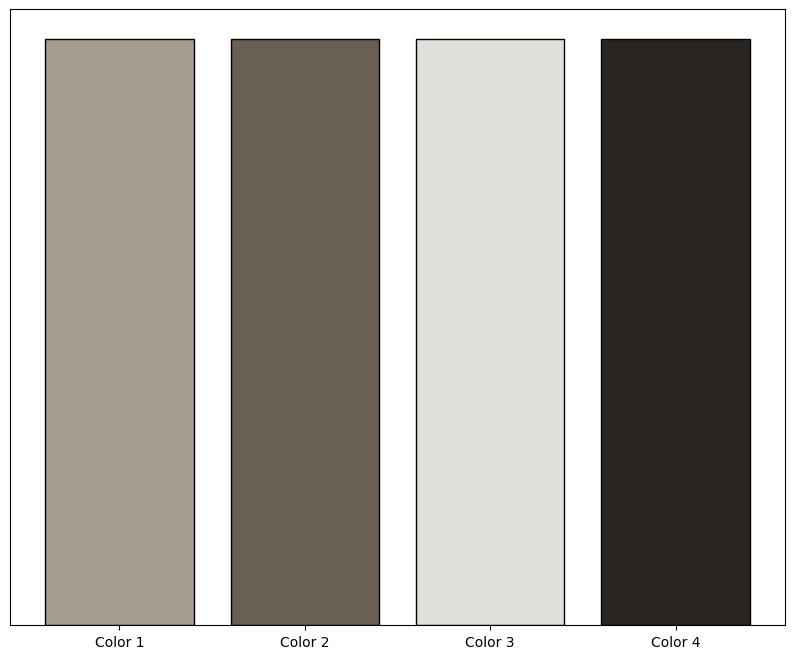

New processed metadata stored successfully.


In [6]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image


#we are getting the average color of all images here to tag them otherwise especially via user input
#it would be too long to do it for each image but the idea is the same, 


# Load original metadata
with open('images/image_metadata.json') as f:
    images_metadata = json.load(f)

# Function to convert RGB color to hex
def convert_color_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(int(color[0]), int(color[1]), int(color[2]))

# Function to find predominant colors using KMeans clustering
def find_dominant_colors(image_np, num_colors=4):
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(image_np)
    colors = kmeans.cluster_centers_
    return colors

# Function to downsample an image to reduce memory usage
def downsample_image(image, max_size=256):
    """Downsample the image to reduce its size."""
    factor = min(max_size / max(image.size), 1)
    size = int(factor * image.size[0]), int(factor * image.size[1])
    return image.resize(size, Image.ANTIALIAS)

# Function to check if the file is an image based on its extension
def is_image_file(filename):
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_image_extensions)


def plot_color_bars(colors, counts):
    # Create an empty figure and axis to plot on
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a bar for each color with the correct color and height
    for i, (color, count) in enumerate(zip(colors, counts)):
        ax.bar(i, count, color=np.clip(color, 0, 255) / 255, edgecolor='black')
    
    # Set the x-ticks to correspond to the bars
    plt.xticks(range(len(colors)), [f'Color {i+1}' for i in range(len(colors))])
    plt.yticks([])  # Hide y-ticks
    
    # Show the plot
    plt.show()





# Collect all colors from all images
all_colors = np.array([]).reshape(0, 3)

for metadata in images_metadata:
    image_name = metadata['image_name']
    if not is_image_file(image_name):
        continue  # Skip files that aren't images

    image_path = os.path.join('images', image_name)
    with Image.open(image_path) as img:
        # Ensure the image is in RGB mode and downsample it
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = downsample_image(img)
        image_np = np.array(img)
        all_colors = np.vstack((all_colors, image_np.reshape((-1, 3))))

# Find the 4 most dominant colors across all images
dominant_colors = find_dominant_colors(all_colors, num_colors=4)
hex_colors = [convert_color_to_hex(color) for color in dominant_colors]

# Plot dominant colors
plot_color_bars(dominant_colors, [1]*4)  # We just want to show colors, so count is 1

# Process each image and update metadata with the common dominant colors and the 'dog' tag
processed_images_metadata = []
for metadata in images_metadata:
    # Append new data to the processed_images_metadata list
    processed_images_metadata.append({
        'image_name': metadata['image_name'],
        'dominant_colors': hex_colors,  # The common dominant colors
        'user_tags': ['dog']  # The 'dog' tag
    })

# Save the new processed metadata to a separate JSON file
new_metadata_file_path = 'images/processed_image_metadata.json'
with open(new_metadata_file_path, 'w') as f:
    json.dump(processed_images_metadata, f, indent=4)

print("New processed metadata stored successfully.")
